In [1]:
# Config
import os
import json
import geojson
import leafmap.leafmap as leafmap
import requests
from PIL import Image

# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Monitoring
from tqdm.notebook import tqdm

# IO
from os.path import join, exists, basename, dirname, splitext, expanduser
from glob import glob
from shapely.geometry import Point
from shapely import vectorized

import geopandas as gpd

# Parallel processing
from joblib import Parallel, delayed
import concurrent.futures as cf

import rioxarray as rxr

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

False

In [2]:
region = "test_wb" # "uttar_pradesh", "delhi_airshed", "wb_small_airshed", "lucknow_data", "ahmedabad_10km_buffer", "bihar"

download_dir = "./raw_data"
quarter = "2024q1"
PLANET_API_KEY="PLAKea85382c048b4ba086c40e3823d83d11" #zeel
# Planet API Key PLAK728a0100ad5746d4ab8e06a617215030 # shataxi

# PLANET_API_KEY = os.getenv("PLANET_API_KEY")
print(PLANET_API_KEY)
assert PLANET_API_KEY is not None
# shape_path = f"../regions/shapes/{region}.geojson"
# shape_path = f"/home/patel_zeel/kiln_compass_24/raw_shapefiles/LUCKNOW.geojson"
# shape_path = f'/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/regions/shapes/lucknow_airshed.geojson'
# shape_path = '/home/patel_zeel/kiln_compass_24/regions/shapes/ahmedabad_10km_buffer.geojson'
shape_path = '/home/patel_zeel/kiln_compass_24/raw_shapefiles/wb_small_airshed.geojson'
# shape_path = '/home/shataxi.dubey/shataxi_work/neurips_2025/zigzag_fcbk_west_bengal.geojson'

print(shape_path)

shape_gdf = gpd.read_file(shape_path)
shape_gdf = shape_gdf.to_crs("EPSG:4326")
# shape_gdf=shape_gdf[]
# print()
print(shape_gdf.crs)
print(shape_gdf.tail()) 
print(shape_gdf.shape)

#Accessing the first row of the geodataframe
# print(shape_gdf.iloc[0])
# shape_gdf=shape_gdf.iloc[0]

PLAKea85382c048b4ba086c40e3823d83d11
/home/patel_zeel/kiln_compass_24/raw_shapefiles/wb_small_airshed.geojson
EPSG:4326
                                            geometry
0  POLYGON ((87.80000 22.05000, 87.80000 22.33000...
(1, 1)


In [3]:
# shape_gdf = shape_gdf.iloc[[0]]
print(shape_gdf.shape)
print(type(shape_gdf))
print(shape_gdf)
## save the shapefile
# shape_gdf.to_file(f"../regions/shapes/{region}.geojson", driver="GeoJSON")

(1, 1)
<class 'geopandas.geodataframe.GeoDataFrame'>
                                            geometry
0  POLYGON ((87.80000 22.05000, 87.80000 22.33000...


In [4]:
##aceess the Rajshahi division

# shape_gdf = shape_gdf[shape_gdf["State_Name"] == f"{region}"]
# shape_gdf.plot()

In [ ]:
m = leafmap.Map()
m.add_basemap("HYBRID")
m.add_gdf(shape_gdf, zoom_to_layer=True)
m

In [5]:
headers = {"Authorization": f"api-key {PLANET_API_KEY}"}
params = {
    "name__contains": quarter,
}

response = requests.get(f"https://api.planet.com/basemaps/v1/mosaics", headers=headers, params=params)
response.json()

{'_links': {'_self': 'https://api.planet.com/basemaps/v1/mosaics?api_key=PLAKea85382c048b4ba086c40e3823d83d11'},
 'mosaics': [{'_links': {'_self': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3?api_key=PLAKea85382c048b4ba086c40e3823d83d11',
    'quads': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads?api_key=PLAKea85382c048b4ba086c40e3823d83d11&bbox={lx},{ly},{ux},{uy}',
    'tiles': 'https://tiles.planet.com/basemaps/v1/planet-tiles/global_quarterly_2024q1_mosaic/gmap/{z}/{x}/{y}.png?api_key=PLAKea85382c048b4ba086c40e3823d83d11'},
   'bbox': [-179.999999974944,
    -59.623325217855,
    179.999999975056,
    76.016093660188],
   'coordinate_system': 'EPSG:3857',
   'datatype': 'byte',
   'first_acquired': '2024-01-01T00:00:00.000Z',
   'grid': {'quad_size': 4096, 'resolution': 4.777314267823516},
   'id': 'a378ff71-e48b-4602-9993-bb2896a68ab3',
   'interval': '3 mons',
   'item_types': ['PSScene'],
   'last_acqui

In [9]:
assert len(response.json()["mosaics"]) == 1
mosaic = response.json()["mosaics"][0]
print(mosaic['name'])
print(mosaic['id'])

global_quarterly_2024q1_mosaic
a378ff71-e48b-4602-9993-bb2896a68ab3


In [43]:
print(download_dir)
# region='rajshahi'
metadata_save_dir = join(download_dir, "metadata", region, mosaic['name'])
print(metadata_save_dir)

./raw_data
./raw_data/metadata/test_wb/global_quarterly_2024q1_mosaic


In [10]:
min_lon, min_lat, max_lon, max_lat = shape_gdf.bounds.values[0]
print(min_lon, min_lat, max_lon, max_lat)

87.8 22.05 88.0 22.33


In [11]:
if shape_gdf.bounds.values.shape[0] > 1:
    min_lon, min_lat = shape_gdf.bounds.values[:,[0,1]].min(axis = 0)
    max_lon, max_lat = shape_gdf.bounds.values[:,[2,3]].max(axis = 0)
    print(min_lon, min_lat, max_lon, max_lat)

In [15]:
params = {
    "bbox": f"{min_lon},{min_lat},{max_lon},{max_lat}",
    "_page_size": 10000,
}

response = requests.get(f"https://api.planet.com/basemaps/v1/mosaics/{mosaic['id']}/quads", headers=headers, params=params)
quads = response.json()['items']
print("Number of quads:", len(quads))
response.json()

Number of quads: 6


{'_links': {'_self': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads?_page_size=10000&api_key=PLAKea85382c048b4ba086c40e3823d83d11&bbox=87.8%2C22.05%2C88.0%2C22.33'},
 'items': [{'_links': {'_self': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1523-1154?api_key=PLAKea85382c048b4ba086c40e3823d83d11',
    'download': 'https://link.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1523-1154/full?api_key=PLAKea85382c048b4ba086c40e3823d83d11',
    'items': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1523-1154/items?api_key=PLAKea85382c048b4ba086c40e3823d83d11',
    'thumbnail': 'https://tiles.planet.com/basemaps/v1/planet-tiles/global_quarterly_2024q1_mosaic/gmap/11/1523/893.png?api_key=PLAKea85382c048b4ba086c40e3823d83d11'},
   'bbox': [87.71484373787362,
    22.268764036188898,
    87.89062498784921,
    22.43134015345633],
   'id': '1523-1154

  0%|          | 0/6 [00:00<?, ?it/s]

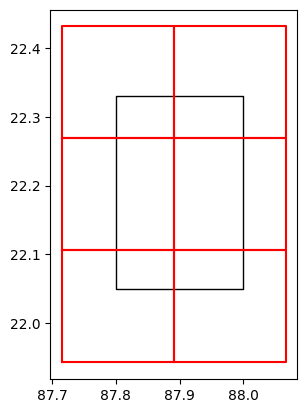

In [16]:
shape_gdf.plot(color="none", edgecolor="black")
for quad in tqdm(quads):
    bounds = quad['bbox']
    plt.plot([bounds[0], bounds[2], bounds[2], bounds[0], bounds[0]], [bounds[1], bounds[1], bounds[3], bounds[3], bounds[1]], color="red")

In [48]:
quads

[{'_links': {'_self': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1435-1159?api_key=PLAKea85382c048b4ba086c40e3823d83d11',
   'download': 'https://link.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1435-1159/full?api_key=PLAKea85382c048b4ba086c40e3823d83d11',
   'items': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1435-1159/items?api_key=PLAKea85382c048b4ba086c40e3823d83d11',
   'thumbnail': 'https://tiles.planet.com/basemaps/v1/planet-tiles/global_quarterly_2024q1_mosaic/gmap/11/1435/888.png?api_key=PLAKea85382c048b4ba086c40e3823d83d11'},
  'bbox': [72.24609374002206,
   23.07973175946952,
   72.42187498999763,
   23.241346099386924],
  'id': '1435-1159',
  'percent_covered': 100},
 {'_links': {'_self': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1436-1159?api_key=PLAKea85382c048b4ba086c40e3823d83d11',
   'download': 'https://link

In [17]:
bboxes = np.array([quad['bbox'] for quad in quads])
print(f"{bboxes.shape=}")

top_left_inside = vectorized.contains(shape_gdf.geometry.item(), bboxes[:, 0], bboxes[:, 3])
top_right_inside = vectorized.contains(shape_gdf.geometry.item(), bboxes[:, 2], bboxes[:, 3])
bottom_left_inside = vectorized.contains(shape_gdf.geometry.item(), bboxes[:, 0], bboxes[:, 1])
bottom_right_inside = vectorized.contains(shape_gdf.geometry.item(), bboxes[:, 2], bboxes[:, 1])
one_of_the_corners_inside = np.logical_or(np.logical_or(top_left_inside, top_right_inside), np.logical_or(bottom_left_inside, bottom_right_inside))
print(f"{one_of_the_corners_inside.sum()=}")

bboxes.shape=(6, 4)
one_of_the_corners_inside.sum()=6


In [50]:
# if shape_gdf.bounds.values.shape[0] > 1:
#     # Extract bounding box corner coordinates
#     top_left = np.column_stack((bboxes[:, 0], bboxes[:, 3]))   # (min_lon, max_lat)
#     top_right = np.column_stack((bboxes[:, 2], bboxes[:, 3]))  # (max_lon, max_lat)
#     bottom_left = np.column_stack((bboxes[:, 0], bboxes[:, 1]))  # (min_lon, min_lat)
#     bottom_right = np.column_stack((bboxes[:, 2], bboxes[:, 1]))  # (max_lon, min_lat)

#     # Function to check if any geometry in shape_gdf contains the given points
#     def check_corners(points):
#         return np.array([shape_gdf.geometry.contains(Point(x, y)).any() for x, y in points])

#     # Check for each corner
#     top_left_inside = check_corners(top_left)
#     top_right_inside = check_corners(top_right)
#     bottom_left_inside = check_corners(bottom_left)
#     bottom_right_inside = check_corners(bottom_right)

#     # Check if at least one corner is inside any geometry
#     one_of_the_corners_inside = np.logical_or.reduce((top_left_inside, top_right_inside, bottom_left_inside, bottom_right_inside))

#     print(f"{one_of_the_corners_inside.sum()=}")


In [18]:
np.array(quads)

array([{'_links': {'_self': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1523-1154?api_key=PLAKea85382c048b4ba086c40e3823d83d11', 'download': 'https://link.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1523-1154/full?api_key=PLAKea85382c048b4ba086c40e3823d83d11', 'items': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1523-1154/items?api_key=PLAKea85382c048b4ba086c40e3823d83d11', 'thumbnail': 'https://tiles.planet.com/basemaps/v1/planet-tiles/global_quarterly_2024q1_mosaic/gmap/11/1523/893.png?api_key=PLAKea85382c048b4ba086c40e3823d83d11'}, 'bbox': [87.71484373787362, 22.268764036188898, 87.89062498784921, 22.43134015345633], 'id': '1523-1154', 'percent_covered': 100},
       {'_links': {'_self': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1524-1154?api_key=PLAKea85382c048b4ba086c40e3823d83d11', 'download': 'https://link.planet.com/bas

In [19]:
one_of_the_corners_inside

array([ True,  True,  True,  True,  True,  True])

In [20]:
quads_within_roi = np.array(quads)[one_of_the_corners_inside]

In [21]:
quads_within_roi

array([{'_links': {'_self': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1523-1154?api_key=PLAKea85382c048b4ba086c40e3823d83d11', 'download': 'https://link.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1523-1154/full?api_key=PLAKea85382c048b4ba086c40e3823d83d11', 'items': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1523-1154/items?api_key=PLAKea85382c048b4ba086c40e3823d83d11', 'thumbnail': 'https://tiles.planet.com/basemaps/v1/planet-tiles/global_quarterly_2024q1_mosaic/gmap/11/1523/893.png?api_key=PLAKea85382c048b4ba086c40e3823d83d11'}, 'bbox': [87.71484373787362, 22.268764036188898, 87.89062498784921, 22.43134015345633], 'id': '1523-1154', 'percent_covered': 100},
       {'_links': {'_self': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1524-1154?api_key=PLAKea85382c048b4ba086c40e3823d83d11', 'download': 'https://link.planet.com/bas

In [22]:
quads_within_roi = np.array(quads)[one_of_the_corners_inside]
quads_within_roi.shape

(6,)

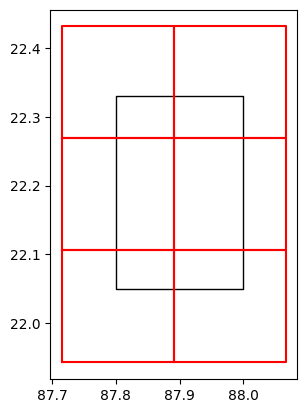

In [23]:
shape_gdf.plot(color="none", edgecolor="black")
for quad in quads_within_roi:
    bounds = quad['bbox']
    plt.plot([bounds[0], bounds[2], bounds[2], bounds[0], bounds[0]], [bounds[1], bounds[1], bounds[3], bounds[3], bounds[1]], color="red")

In [24]:
# each item in quads_within_roi is a dict. Combine into a geojson feature collection
features = []
for quad in tqdm(quads_within_roi):
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[
                [quad['bbox'][0], quad['bbox'][1]],
                [quad['bbox'][2], quad['bbox'][1]],
                [quad['bbox'][2], quad['bbox'][3]],
                [quad['bbox'][0], quad['bbox'][3]],
                [quad['bbox'][0], quad['bbox'][1]],
            ]],
        },
        "properties": {
            "_self": quad['_links']['_self'],
            "download": quad['_links']['download'],
            "items": quad['_links']['items'],
            "thumbnail": quad['_links']['thumbnail'],
            "id": quad['id'],
            "percent_covered": quad['percent_covered'],
        }
    }
    features.append(feature)
    
collection = geojson.FeatureCollection(features)

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
os.makedirs(metadata_save_dir, exist_ok=True)
with open(join(metadata_save_dir, "metadata.geojson"), "w") as f:
    geojson.dump(collection, f)

In [18]:
with open(join(metadata_save_dir, "metadata.geojson"), "r") as f:
    collection = geojson.load(f)

In [25]:
features = collection['features']
print(f"{len(features) = }")
set([feature['properties']['percent_covered'] for feature in features])

len(features) = 6


{100}

In [26]:
print(features[0])

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[87.71484373787362, 22.268764036188898], [87.89062498784921, 22.268764036188898], [87.89062498784921, 22.43134015345633], [87.71484373787362, 22.43134015345633], [87.71484373787362, 22.268764036188898]]]}, 'properties': {'_self': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1523-1154?api_key=PLAKea85382c048b4ba086c40e3823d83d11', 'download': 'https://link.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1523-1154/full?api_key=PLAKea85382c048b4ba086c40e3823d83d11', 'items': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1523-1154/items?api_key=PLAKea85382c048b4ba086c40e3823d83d11', 'thumbnail': 'https://tiles.planet.com/basemaps/v1/planet-tiles/global_quarterly_2024q1_mosaic/gmap/11/1523/893.png?api_key=PLAKea85382c048b4ba086c40e3823d83d11', 'id': '1523-1154', 'percent_covered': 100}}


In [22]:
download_imagery_dir = join(download_dir, f"{region}_imagery", mosaic['name'])
print(download_imagery_dir)
os.makedirs(download_imagery_dir, exist_ok=True)

./raw_data/ahmedabad_10km_buffer_imagery/global_quarterly_2024q1_mosaic


In [ ]:


def download_feature(feature):
    file_id = feature['properties']['id']
    file_path = join(download_imagery_dir, f"{file_id}.tif")
    
    download_url = feature['properties']['download']
    if exists(file_path):
        try:
            image = Image.open(file_path)
            assert image.size == (4096, 4096)
            # print(f"File already exists: {file_path}.")
            return  # Skip if the file is already downloaded and is not corrupted
        except:
            print(f"Corrupted file: {file_path}.")

    response = requests.get(download_url, headers=headers)

    # print(f"{response.status_code=}")
    with open(file_path, "wb") as f:
        f.write(response.content)
        
    da = rxr.open_rasterio(file_path)
    # round x, y to 6 decimal places
    da = da.assign_coords(x=np.round(da.x, 6))
    da = da.assign_coords(y=np.round(da.y, 6))
    kwargs = {'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
    da.rio.to_raster(file_path, **kwargs)
    
    # reload for testing
    # reload_da = rxr.open_rasterio(file_path)
    # return reload_da

# test
# da = download_feature(features[0])
# da.x.values[0:5]
# _ = Parallel(n_jobs=48)(delayed(download_feature)(feature) for feature in tqdm(features))
with cf.ThreadPoolExecutor(max_workers=48) as executor:
    list(tqdm(executor.map(download_feature, features), total=len(features)))

  0%|          | 0/6 [00:00<?, ?it/s]

NameError: name 'download_imagery_dir' is not defined

In [35]:
file_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/raw_data/wb_small_airshed_imagery/global_quarterly_2024q1_mosaic/1523-1152.tif'
da = rxr.open_rasterio(file_path)
print(da)
print(f'------da.x {da.x}')
da.assign_coords??

<xarray.DataArray (band: 4, y: 4096, x: 4096)>
[67108864 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 9.764e+06 9.764e+06 ... 9.784e+06 9.784e+06
  * y            (y) float64 2.524e+06 2.524e+06 ... 2.505e+06 2.505e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
------da.x <xarray.DataArray 'x' (x: 4096)>
array([9764374.128569, 9764378.905883, 9764383.683198, ..., 9783927.675864,
       9783932.453179, 9783937.230493])
Coordinates:
  * x            (x) float64 9.764e+06 9.764e+06 ... 9.784e+06 9.784e+06
    spatial_ref  int64 0


Signature: da.assign_coords(coords: 'Mapping | None' = None, **coords_kwargs: 'Any') -> 'Self'
Source:   
    def assign_coords(
        self,
        coords: Mapping | None = None,
        **coords_kwargs: Any,
    ) -> Self:
        """Assign new coordinates to this object.

        Returns a new object with all the original data in addition to the new
        coordinates.

        Parameters
        ----------
        coords : mapping of dim to coord, optional
            A mapping whose keys are the names of the coordinates and values are the
            coordinates to assign. The mapping will generally be a dict or
            :class:`Coordinates`.

            * If a value is a standard data value — for example, a ``DataArray``,
              scalar, or array — the data is simply assigned as a coordinate.

            * If a value is callable, it is called with this object as the only
              parameter, and the return value is used as new coordinate variables.

            

In [36]:
da.rio??

Type:        RasterArray
String form: <rioxarray.raster_array.RasterArray object at 0x7f2d2a874690>
File:        ~/miniconda3/envs/shataxi_space/lib/python3.11/site-packages/rioxarray/raster_array.py
Source:     
@xarray.register_dataarray_accessor("rio")
class RasterArray(XRasterBase):
    """This is the GIS extension for :obj:`xarray.DataArray`"""

    def __init__(self, xarray_obj: xarray.DataArray):
        super().__init__(xarray_obj)
        self._obj: xarray.DataArray
        # properties
        self._nodata: Optional[float] = None
        self._manager: Optional[
            FileManager
        ] = None  # https://github.com/corteva/rioxarray/issues/254

    def set_nodata(
        self, input_nodata: Optional[float], inplace: bool = True
    ) -> xarray.DataArray:
        """
        Set the nodata value for the DataArray without modifying
        the data array.

        Parameters
        ----------
        input_nodata: Optional[float]
            Valid nodata for dtype.
 

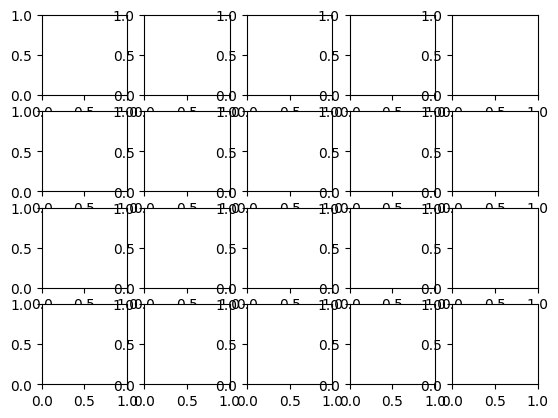

In [27]:
#visualize the downloaded images
import rasterio
import matplotlib.pyplot as plt
from glob import glob
tif_files = glob(f'./raw_data/{region}_imagery/global_quarterly_2024q1_mosaic/*')
fig, ax = plt.subplots(4,5)
ax = ax.flatten()
for i, tif_file in enumerate(tif_files):
    data=rasterio.open(tif_file)
    ax[i].imshow(data.read(1))

In [28]:
corruptepetd_files = "./raw_data/ahmedabad_10km_buffer_imagery/global_quarterly_2024q1_mosaic/1435-1157.tif"
os.remove(corruptepetd_files)
print("Removed corrupted files")


Removed corrupted files
